# Dorothea

There are two ways of describing the city of Dorothea: you can say that four aluminum towers rise from its walls flanking seven gates with spring-operated drawbridges that span the moat whose water feeds four green canals which cross the city, dividing it into nine quarters, each with three hundred houses and seven hundred chimneys. And bearing in mind that the nubile girls of each quarter marry youths of other quarters and their parents exchange the goods that each family holds in monopoly -- bergamot, sturgeon roe, astrolabes, amethysts -- you can then work from these facts until you learn everything you wish about the city in the past, present, and future. Or else you can say, like the camel driver who took me there: “I arrived here in my first youth, one morning, many people were hurrying along the streets toward the market, the women had fine teeth and looked you straight in the eye, three soldiers on a platform played the trumpet, and all around wheels turned and colored banners fluttered in the wind. Before then I had known only the desert and the caravan routes. In the years that followed, my eyes returned to contemplate the desert expanses and the caravan routes; but now I know this path is only one of the many that opened before me on that morning in Dorothea.”

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


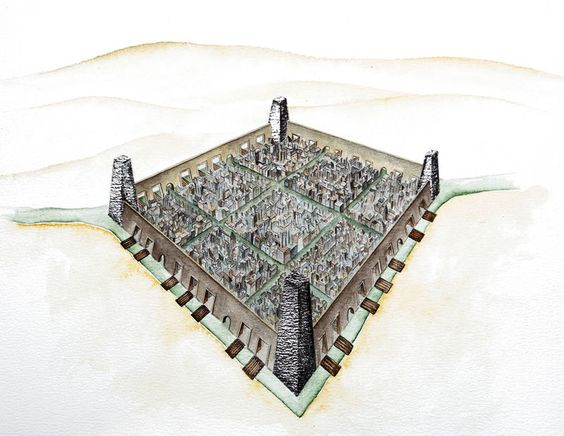

In [4]:
Image(filename='../Images/Dorothea.jpg') 

## DOROTEA

DOROTEA is an alternative version of DIOMIRA. It does the same than DIOMIRA
but adds the RWFs to the existing file with the MCRD, rather than creating a new file 
1) Reads a MCRD file containing MC waveforms for the 12 PMTs of the EP.
   Each waveform contains number of PEs in bins of 1 ns.
2) Convolves the PE waveform with the response of the FEE electronics.
3) Decimates the waveform, simulating the effect of the DAQ sampling (25 ns bins)
4) Writes a RWF file with the new data and adds the FEE simulation parameters as metadata
"""

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [22]:
from LogConfig import *

In [24]:
import logging
import sys

# Get root logger (all other loggers will be derived from this logger's
# properties)
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout

In [26]:

logger.warning("I will output to terminal")  # No output in notebook, goes to terminal

In [27]:
%time %run ../Cities/DOROTEA.py -c ../Config/DOROTEA_NA_ZLIB_test.csv

ConFiguration Parameters (CFP) dictionary  = {'FIRST_EVT': 0, 'LAST_EVT': 100, 'END ': 1, 'RUN_ALL': 1, 'PATH_IN': '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/', 'FILE_IN': 'WF_Na_0.h5'}
Press a key...

        DOROTEA:
        1. Reads an MCRD file produced by NEXUS, which stores TWF1ns waveforms 
            for the PMTs and SiPMs as well as data on geometry, sensors and MC.

        2. Simulates the response of the energy plane in the PMTs  and
            outputs PMT TWF25ns e.g., waveforms in bins of 25 ns (and in adc counts)
            which correspond to the output of the EP FEE.

        3. Adds the RWF to the file. It also adds vectors
            holding the waveform energy in pes (per PMT/SiPM)

        4. Add a table describing the FEE parameters used for simulation


        

  NEW FEE: DEFAULT PARAMETERS
  PMT gain = 4.5e+06
  sampling time: (fine) =    1.00 ns (DAQ) =   25.00 ns 
  decoupling capacitor =    6.20 nF
  decoupling resistor = 235

#### Access the Nh5 DST (generated by DOROTEA)

In [51]:
class NDM:
    import tables as tb
    """
    Represents the hdf5-based NEXT Data MODEL
    
    """   
    def __init__(self, path_to_file, access_mode='r'):
        """
        path_to_file is a full path to a hdf5 DST file
        the default access mode is r+ (read mode even if file not closed)
        
        
        """
        
        self.h5f =tb.open_file(path_to_file, access_mode) 
        
        self.geom_t = self.h5f.root.Detector.DetectorGeometry
        self.pmt_t = self.h5f.root.Sensors.DataPMT
        self.sipm_t = self.h5f.root.Sensors.DataSiPM
        self.mctrk_t = self.h5f.root.MC.MCTracks
        self.fee_t = self.h5f.root.MC.FEE
        
        self.epmt = self.h5f.root.RD.epmt
        self.esipm = self.h5f.root.RD.esipm
        self.pmtrd = self.h5f.root.pmtrd
        self.sipmrd = self.h5f.root.sipmrd
        self.pmtrwf = self.h5f.root.RD.pmtrwf
        self.sipmrwf = self.h5f.root.RD.sipmrwf
    
    def __del__(self):
        self.h5f.close()
        
    def Geometry(self):
        """
        returns a PD series for the geometry data
        """
        ga = self.geom_t.read()
        G = pd.Series([ga[0][0][0],ga[0][0][1],ga[0][1][0],ga[0][1][1],
                    ga[0][2][0],ga[0][2][1],ga[0][3]],
                    index=['xdet_min','xdet_max','ydet_min','ydet_max',
                            'zdet_min','zdet_max','R'])
        return G
    
    def FEE(self):
        """
        Reads the FEE table en returns a PD Series for the simulation parameters 
        and a PD series for the values of the capacitors used in the simulation
        """
        
        fa = self.fee_t.read()
        F = pd.Series([fa[0][0],fa[0][1],fa[0][2],fa[0][3],fa[0][5],fa[0][6],fa[0][7],fa[0][8],fa[0][9],fa[0][10],
                   fa[0][11],fa[0][12]],
                    index=['offset','pmt_gain','V_gain','R',"time_step",
                           "time_daq",
                            "freq_LPF",
                            "freq_HPF",
                            "LSB",
                            "volts_to_adc",
                            "noise_fee_rms",
                            "noise_adc"])
        C =pd.Series([fa[0][4]],index=['C12'])
        return F,C
    
    def get_column_(self,pmta,ic):
        """
        access column ic of table pmta and returns column as an array
        """
        col =[]
        for i in range(pmta.shape[0]):
            col.append(pmta[i][ic])
        return np.array(col)
 
    def Sensors(self,sensor='pmt'):
        """
        reads the sensors table and returns a data frame
        sensor can take the values 'pmt' or 'sipm'
        """
        pmta = eval('self.'+sensor+'_t').read()
        PMT={}
        PMT['channel'] = self.get_column_(pmta,0)
        PMT['active'] = self.get_column_(pmta,1)
        PMT['x'] = self.get_column_(pmta,2).T[0]
        PMT['y'] = self.get_column_(pmta,2).T[1]
        PMT['gain'] = self.get_column_(pmta,3)
        PMT['adc_to_pes'] = self.get_column_(pmta,4)
        
        return pd.DataFrame(PMT)
    
    def SensorsTrueEnergy(self,sensor='pmt'):
        """
        reads the sensors energy and returns a data frame:
        sensor can take the values, pmt or sipm
        """        
        return pd.DataFrame(eval('self.e'+sensor).read())
    
    def get_waveforms_(self,pmtea,event_number):
        """
        Takes the earray pmtea and returns a DF for event_number
        """
    
        PMTWF ={}
        NPMT = pmtea.shape[1]
    
        for j in range(NPMT):
            PMTWF[j] = pmtea[event_number, j] #waveform for event event_number, PMT j
       
        return pd.DataFrame(PMTWF)
    
    def GetMCRD(self,event_number=0):
        return self.get_waveforms_(self.pmtrd,event_number) 
    
    def GetMCRD_ZS(self,event_number=0):
        """
        Zero Suprressed WF
        """
        PMTWF ={}
        NPMT = pmtea.shape[1]
    
        for j in range(NPMT):
            PMTWF[j] = pmtea[event_number, j] #waveform for event event_number, PMT j
       
        return pd.DataFrame(PMTWF)
    
    def __str__(self): 
        return "{}".format(self.h5f.__str__)
        
    
    def __repr__(self): 
        return "{}".format(self.h5f.__repr__)
        
        

In [57]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/WF_Na_0.h5', "r+") 

In [58]:
pmtrd = h5f.root.pmtrd

In [59]:
pmtrd

/pmtrd (EArray(100, 12, 599999), zlib(1)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)

In [60]:
pm0 = pmtrd[0,0]

In [61]:
pm0_zs = [x for x in pm0 if x != 0]

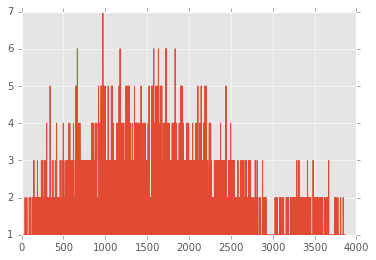

In [63]:
plt.plot(pm0_zs)

In [52]:
ndm = NDM('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/Prod0/WF_Na_0.h5',access_mode='r+')

In [53]:
mcrdDF = ndm.GetMCRD(event_number=0)

In [56]:
mcrdDF

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0
